In [162]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

warnings.filterwarnings('ignore')

In [163]:
pickleModels = {
    'XGBoost': 'serialized/XGBoostModel.pkl',
    'decisionTree': 'serialized/decisionTreeModel.pkl',
    'randomForest': 'serialized/randomForestModel.pkl'
}

# Loading a serialized model
with open(pickleModels['XGBoost'], 'rb') as file:
    model = pickle.load(file)

In [164]:
# New dataset for forecasting
data = {
    'Location': random.choices(['CityA', 'CityB', 'CityC'], k=130),
    'Year': [2023] * 130,
    'Month': random.choices(range(1, 13), k=130),
    'Day': random.choices(range(1, 29), k=130),  # To avoid February issues
    'Hour': random.choices(range(0, 24), k=130),
    'AQI': [random.randint(0, 500) for _ in range(130)],
    'PM2.5': [round(random.uniform(10, 300), 2) for _ in range(130)],
    'PM10': [round(random.uniform(20, 400), 2) for _ in range(130)],
    'O3': [round(random.uniform(5, 150), 2) for _ in range(130)],
    'CO': [round(random.uniform(0.1, 10), 2) for _ in range(130)],
    'SO2': [round(random.uniform(0.5, 50), 2) for _ in range(130)],
    'NO2': [round(random.uniform(1, 100), 2) for _ in range(130)],
}

data = pd.DataFrame(data)
data.head()

,Location,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2
0,CityA,2023,6,13,5,159,138.74,201.88,33.62,3.04,38.24,29.82
1,CityB,2023,1,12,13,227,143.67,235.17,90.17,1.32,42.28,65.69
2,CityB,2023,11,21,6,71,91.93,43.60,7.75,2.14,16.00,4.06
3,CityC,2023,9,1,19,120,189.63,295.68,21.49,9.11,38.59,20.50
4,CityB,2023,2,3,18,27,40.44,354.66,100.43,4.23,37.32,32.32


In [165]:
# Label encoding
le = LabelEncoder()
data['LocationNumeric'] = le.fit_transform(data['Location'])
data['Hour'] = le.fit_transform(data['Hour'])

# Convert hours to numeric format
data['Hour'] = data['Hour'].astype(str).str.split(":").str[0].astype(int)

# Feature selection
X_new = data[['LocationNumeric', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]

In [166]:
# Data scaling (as in the training model)
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(X_new)

In [167]:
# Prognostication
predictions = model.predict(X_new_scaled)

df_full = X_new.copy()
df_full['AQI'] = predictions
print("Input data:")
print(df_full)

Input data:
     LocationNumeric  Year  Month  Day  Hour   PM2.5    PM10      O3    CO  \
0                  0  2023      6   13     5  138.74  201.88   33.62  3.04   
1                  1  2023      1   12    13  143.67  235.17   90.17  1.32   
2                  1  2023     11   21     6   91.93   43.60    7.75  2.14   
3                  2  2023      9    1    19  189.63  295.68   21.49  9.11   
4                  1  2023      2    3    18   40.44  354.66  100.43  4.23   
..               ...   ...    ...  ...   ...     ...     ...     ...   ...   
125                0  2023      7   10    19  160.23  259.14  102.00  5.59   
126                0  2023      6    9     2  263.23  365.18  133.83  3.95   
127                0  2023      7    6    11  256.67  274.38   45.50  8.62   
128                2  2023      1   10     4  246.18   69.96   23.47  7.01   
129                2  2023      4    7     0  236.17  221.13   67.57  3.97   

       SO2    NO2         AQI  
0    38.24  29.82  

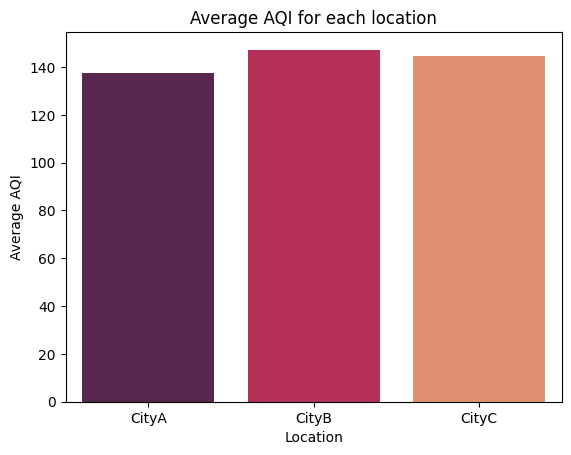

In [168]:
# --- 1. Analysis by location ---
# Average AQI for each location
df_full['Location'] = data['Location']
location_aqi = df_full.groupby('Location')['AQI'].mean().reset_index()
sns.barplot(data=location_aqi, x='Location', y='AQI', palette='rocket')
plt.title('Average AQI for each location')
plt.xlabel('Location')
plt.ylabel('Average AQI')
plt.show()

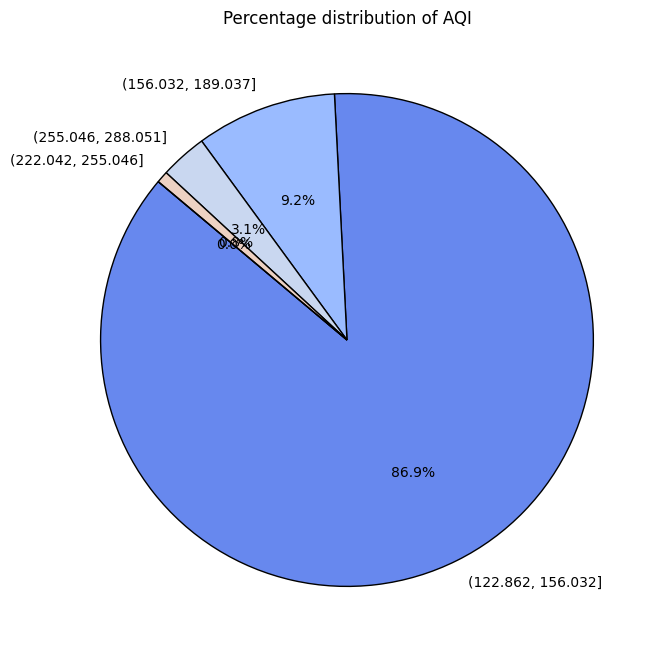

In [169]:
# --- 2. Grouping data by AQI ---
aqi_class_distribution = df_full['AQI'].value_counts(bins=5)

# Побудова кругової діаграми
plt.figure(figsize=(8, 8))
aqi_class_distribution.plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('coolwarm'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Percentage distribution of AQI')
plt.ylabel('')  # Remove the Y axis label
plt.show()

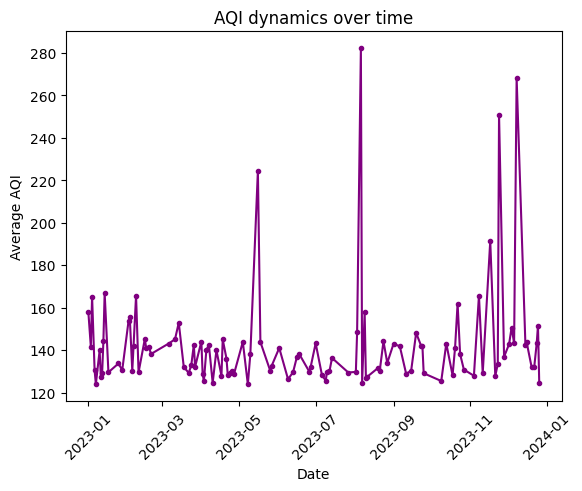

In [170]:
# --- 3. Time Analysis ---
# Line graph of AQI changes over time
df_full['Date'] = pd.to_datetime(df_full[['Year', 'Month', 'Day']])
time_aqi = df_full.groupby('Date')['AQI'].mean().reset_index()
plt.plot(time_aqi['Date'], time_aqi['AQI'], marker='.', linestyle='-', color='purple')
plt.title('AQI dynamics over time')
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.xticks(rotation=45)
plt.show()

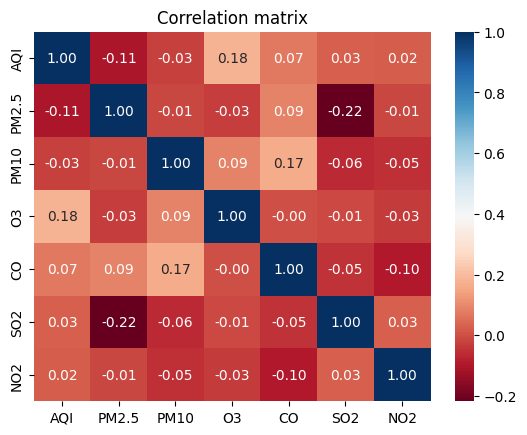

In [171]:
# --- 4. Correlation between variables ---
# Correlation matrix
corr_matrix = data[['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Correlation matrix')
plt.show()